In [1]:
! pip install -q scikit-plot

# **Import**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/DeepLearning')

In [4]:
from utils.basic_utilities import Utils
from models.LSTM_1 import LSTM_Model
from models.CNN_1 import CNN_Model
from models.Word2Vec_1 import Word2VecModel
from models.BiLSTM import BiLSTM_Model

In [5]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

# **Reading Preprocessed Data**

In [6]:
df = pd.read_csv('/content/drive/MyDrive/DeepLearning/Data/preprocessed_data.csv')
df.head()

,emotion,content,original_content,text
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat nsorry spot disappointedface,b'RT @Davbingodav: @mcrackins Oh fuck.... did I wrote Fil ??? :grinning_face_with_sweat:\nSorry Spot. :disappointed_face:',rt oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it,feel shamed
2,disappointed,i had been feeling a little bit defeated by the step of faith we would need to take to try to resolve our problem,i had been feeling a little bit defeated by the steps of faith we would need to take to try to resolve our problem,feeling little bit defeated steps faith need try resolve problem
3,happy,imagine if that reaction guy that called jj kfc saw this my man would ve started cry lmao,"b""@KSIOlajidebt imagine if that reaction guy that called JJ KFC saw this. my man would've started crying lmao """,imagine reaction guy called jj kfc saw man ve started crying lmao
4,disappointed,i wouldnt feel burdened so that i would live my life a a testament to his sacrifice that wa out of a love so pure and innocent yet so great and mighty,i wouldnt feel burdened so that i would live my life as a testament to his sacrifice that was out of a love so pure and innocent yet so great and mighty,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty


In [7]:
df.text = df.text.astype(str)

# **Splitting dataset into train(90%) and test(10%)**

In [8]:
util = Utils()
X_train, X_test, y_train, y_test = util.split_data(df)
print("The shape of train data: ",X_train.shape)
print("The shape of train target: ",y_train.shape)
print("The shape of test data: ",X_test.shape)
print("The shape of test target: ",y_test.shape)

Initialization of Utilities...
The shape of train data:  (824917,)
The shape of train target:  (824917,)
The shape of test data:  (91658,)
The shape of test target:  (91658,)


# **Tokenization and Padding of each tweet**

In [9]:
max_len = util.max_len(df)
print("Maximum length of tweet:", max_len)

Maximum length of tweet: 122


In [10]:
train_converted, test_converted = util.tokenization_padding(X_train, X_test, max_len)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (824917, 122)
The shape of test data:  (91658, 122)


In [11]:
target_converted_train, target_converted_test = util.one_hot_target_variable(y_train, y_test)
print("After one hot encoding of target variable...")
print("The shape of train target: ", target_converted_train.shape)
print("The shape of test target: ", target_converted_test.shape)

After one hot encoding of target variable...
The shape of train target:  (824917, 3)
The shape of test target:  (91658, 3)


# **Deep Learning Models**

In [12]:
EPOCH = 30
BATCH_SIZE = 1024

# **CNN Model**

In [13]:
cnn = CNN_Model()
model = cnn.create_model(embed_dim = 100, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = 200000, 
                          drop_out = 0.7, num_words=4)
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 122, 100)          20000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 122, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 128)          51328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 20,051,715
Trainable params: 20,051,715
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.1,
                    callbacks=cnn.callbacks)

Epoch 1/30
726/726 [==============================] - 192s 220ms/step - loss: 0.4815 - acc: 0.7858 - val_loss: 0.2423 - val_acc: 0.8948

Epoch 00001: val_loss improved from inf to 0.24226, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/CNN/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/CNN/assets
Epoch 2/30
726/726 [==============================] - 159s 218ms/step - loss: 0.2336 - acc: 0.9026 - val_loss: 0.2340 - val_acc: 0.8989

Epoch 00002: val_loss improved from 0.24226 to 0.23401, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/CNN/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/CNN/assets
Epoch 3/30
726/726 [==============================] - 158s 218ms/step - loss: 0.2109 - acc: 0.9133 - val_loss: 0.2307 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.23401 to 0.23066, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/CNN/
INFO:tensorflow:Assets written

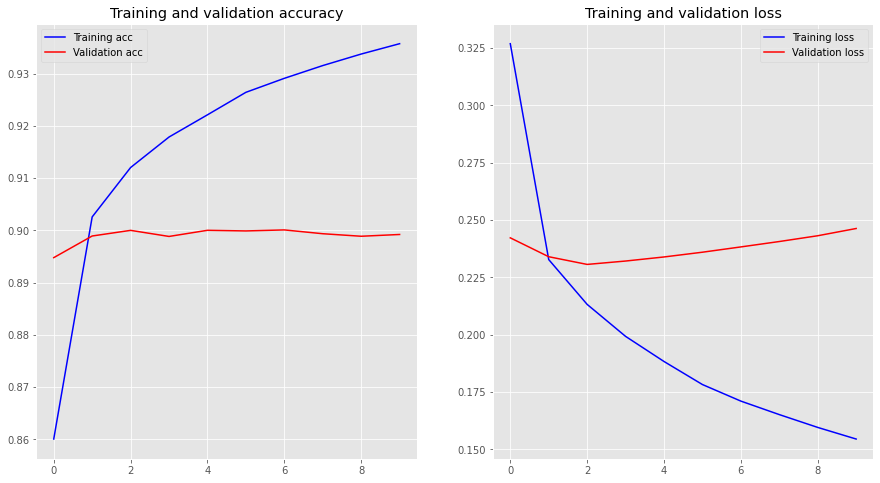

In [15]:
util.plot_accuracy_loss(history, 'CNN')

# **Evaluation**

In [16]:
model = cnn.load_saved_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 122, 100)          20000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 122, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 128)          51328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 20,051,715
Trainable params: 20,051,715
Non-trainable params: 0
_________________________________________________________________


In [17]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 2s - loss: 0.2278 - acc: 0.9013
The loss of this model: 0.23
The accuracy of this model: 0.90


In [18]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[27316  4034  1202]
 [ 2527 27017   711]
 [  256   321 28274]]


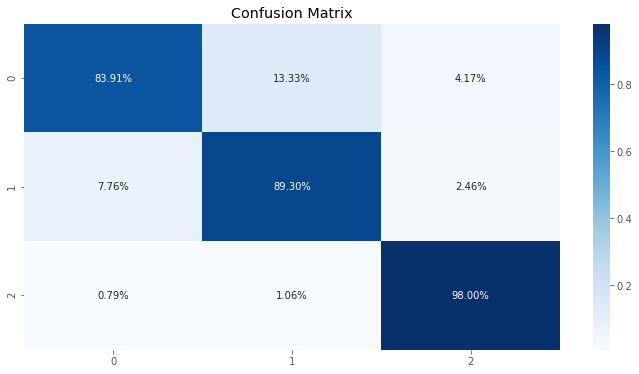

In [19]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN')

In [20]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.91      0.84      0.87     32552
           1       0.86      0.89      0.88     30255
           2       0.94      0.98      0.96     28851

    accuracy                           0.90     91658
   macro avg       0.90      0.90      0.90     91658
weighted avg       0.90      0.90      0.90     91658



# **LSTM Model**

In [21]:
lstm = LSTM_Model()
model = lstm.create_model(embed_dim = 100, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = 200000, 
                          drop_out = 0.7)
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 122, 100)          20000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 122, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 20,042,435
Trainable params: 20,042,435
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.1,
                    callbacks=lstm.callbacks)

Epoch 1/30
726/726 [==============================] - 488s 669ms/step - loss: 0.6009 - acc: 0.7278 - val_loss: 0.2580 - val_acc: 0.8890

Epoch 00001: val_loss improved from inf to 0.25803, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/LSTM/assets
Epoch 2/30
726/726 [==============================] - 492s 678ms/step - loss: 0.2758 - acc: 0.8852 - val_loss: 0.2432 - val_acc: 0.8969

Epoch 00002: val_loss improved from 0.25803 to 0.24318, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/LSTM/assets
Epoch 3/30
726/726 [==============================] - 485s 667ms/step - loss: 0.2473 - acc: 0.8976 - val_loss: 0.2363 - val_acc: 0.8981

Epoch 00003: val_loss improved from 0.24318 to 0.23630, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/LSTM/
INFO:tensorflow:Assets wr

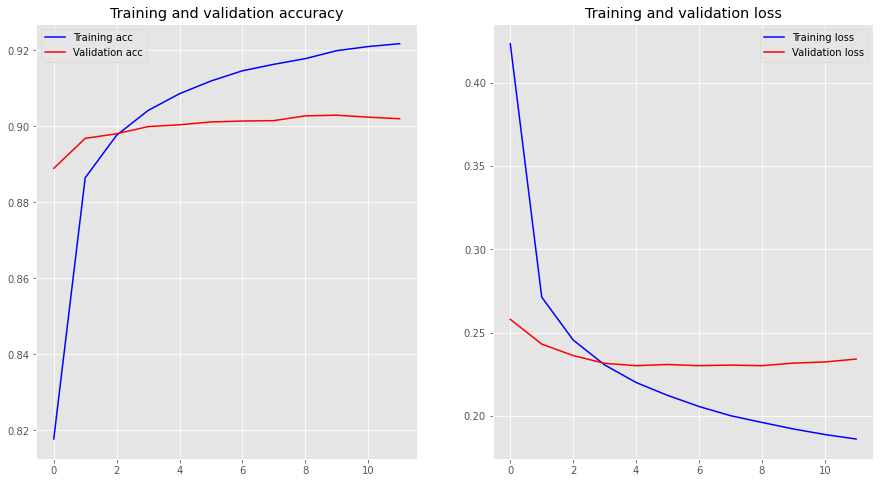

In [23]:
util.plot_accuracy_loss(history, 'LSTM')

# **Evaluation**

In [24]:
model = lstm.load_saved_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 122, 100)          20000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 122, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 20,042,435
Trainable params: 20,042,435
Non-trainable params: 0
_________________________________________________________________


In [25]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 4s - loss: 0.2277 - acc: 0.9033
The loss of this model: 0.23
The accuracy of this model: 0.90


In [26]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[27087  3693  1111]
 [ 2800 27424   788]
 [  212   255 28288]]


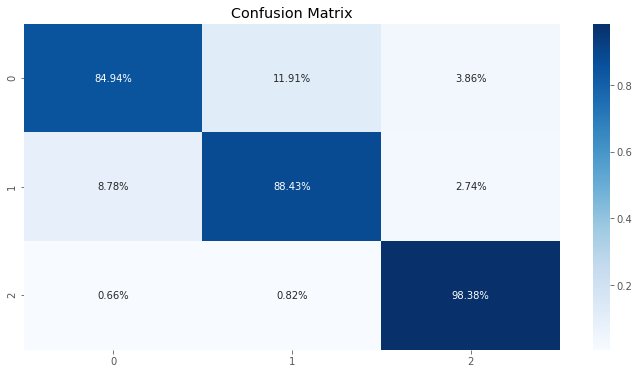

In [27]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM')

In [28]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.85      0.87     31891
           1       0.87      0.88      0.88     31012
           2       0.94      0.98      0.96     28755

    accuracy                           0.90     91658
   macro avg       0.90      0.91      0.90     91658
weighted avg       0.90      0.90      0.90     91658



# **Word2Vec Model**

In [29]:
word2vec = Word2VecModel()
word2vec_model = word2vec.create_model(X_train)

Word2Vec Model Initialization...
Vocabulary Length: 37148


In [30]:
train_converted, test_converted, tokenizer = util.tokenization_padding_oov_token(X_train, X_test, 60)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (824917, 60)
The shape of test data:  (91658, 60)


In [31]:
vocab_length = len(tokenizer.word_index) + 1
embedding_matrix = word2vec.create_embedding_matrix(vocab_length, tokenizer, word2vec_model)

Embedding Matrix Shape: (170216, 100)


# **BiLSTM**

In [32]:
bi_lstm = BiLSTM_Model()
model = bi_lstm.create_model(embed_dim = 100, lstm_out = 100, input_len = train_converted.shape[1], 
                             feature = vocab_length, drop_out = 0.3, embedding_matrix = embedding_matrix)
model.summary()

BiLSTM Model Initialization...
Model Created Successfully...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 100)           17021600  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
___________________________________________________________

In [33]:
history = model.fit(train_converted, target_converted_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=0.1, callbacks=bi_lstm.callbacks, verbose=1)

Epoch 1/30
726/726 [==============================] - 92s 120ms/step - loss: 0.4126 - acc: 0.8208 - val_loss: 0.2387 - val_acc: 0.8946

Epoch 00001: val_loss improved from inf to 0.23872, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 2/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2471 - acc: 0.8906 - val_loss: 0.2348 - val_acc: 0.8963

Epoch 00002: val_loss improved from 0.23872 to 0.23482, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 3/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2378 - acc: 0.8941 - val_loss: 0.2334 - val_acc: 0.8968

Epoch 00003: val_loss improved from 0.23482 to 0.23337, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 4/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2324 - acc: 0.8957 - val_loss: 0.2317 - val_acc: 0.8976

Epoch 00004: val_loss improved from 0.23337 to 0.23167, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 5/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2292 - acc: 0.8982 - val_loss: 0.2276 - val_acc: 0.8987

Epoch 00005: val_loss improved from 0.23167 to 0.22761, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 6/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2269 - acc: 0.8989 - val_loss: 0.2253 - val_acc: 0.9000

Epoch 00006: val_loss improved from 0.22761 to 0.22527, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 7/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2245 - acc: 0.8995 - val_loss: 0.2265 - val_acc: 0.8999

Epoch 00007: val_loss did not improve from 0.22527
Epoch 8/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2236 - acc: 0.9001 - val_loss: 0.2244 - val_acc: 0.9006

Epoch 00008: val_loss improved from 0.22527 to 0.22441, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 9/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2210 - acc: 0.9014 - val_loss: 0.2244 - val_acc: 0.9006

Epoch 00009: val_loss did not improve from 0.22441
Epoch 10/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2196 - acc: 0.9018 - val_loss: 0.2228 - val_acc: 0.9008

Epoch 00010: val_loss improved from 0.22441 to 0.22280, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 11/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2191 - acc: 0.9020 - val_loss: 0.2233 - val_acc: 0.9015

Epoch 00011: val_loss did not improve from 0.22280
Epoch 12/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2170 - acc: 0.9030 - val_loss: 0.2221 - val_acc: 0.9016

Epoch 00012: val_loss improved from 0.22280 to 0.22208, saving model to /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/checkpoints/BiLSTM/assets


Epoch 13/30
726/726 [==============================] - 87s 119ms/step - loss: 0.2150 - acc: 0.9042 - val_loss: 0.2256 - val_acc: 0.9005

Epoch 00013: val_loss did not improve from 0.22208
Epoch 14/30
726/726 [==============================] - 86s 119ms/step - loss: 0.2134 - acc: 0.9050 - val_loss: 0.2241 - val_acc: 0.9015

Epoch 00014: val_loss did not improve from 0.22208
Epoch 15/30
726/726 [==============================] - 86s 119ms/step - loss: 0.2130 - acc: 0.9049 - val_loss: 0.2224 - val_acc: 0.9018

Epoch 00015: val_loss did not improve from 0.22208
Epoch 16/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2108 - acc: 0.9062 - val_loss: 0.2231 - val_acc: 0.9012

Epoch 00016: val_loss did not improve from 0.22208
Epoch 17/30
726/726 [==============================] - 86s 118ms/step - loss: 0.2092 - acc: 0.9069 - val_loss: 0.2229 - val_acc: 0.9016

Epoch 00017: val_loss did not improve from 0.22208


# **Evaluation**

In [34]:
model = bi_lstm.load_saved_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 100)           17021600  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [35]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 5s - loss: 0.2210 - acc: 0.9023
The loss of this model: 0.22
The accuracy of this model: 0.90


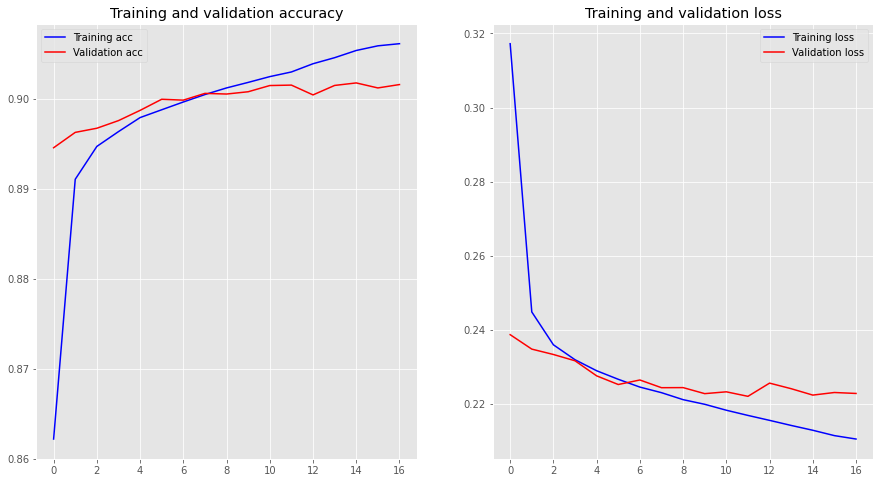

In [36]:
util.plot_accuracy_loss(history, 'BiLSTM')

# **Prediction** 

In [37]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[27832  4503  1297]
 [ 2071 26605   623]
 [  196   264 28267]]


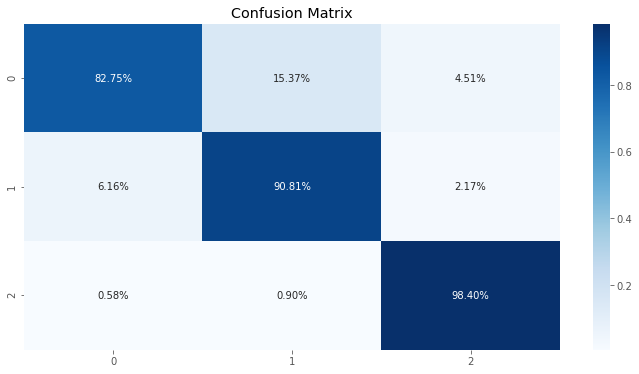

In [38]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'BiLSTM')

In [39]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.92      0.83      0.87     33632
           1       0.85      0.91      0.88     29299
           2       0.94      0.98      0.96     28727

    accuracy                           0.90     91658
   macro avg       0.90      0.91      0.90     91658
weighted avg       0.90      0.90      0.90     91658

